# Table of Contents | ASD DATA 

- [The BREAST-CANCER dataset](#The-BREAST-CANCER-dataset):
    - [Load the dataset](#Load-the-Dataset)
    - [Explore the dataset: Descriptive statistics](#Explore-the-dataset:-Descriptive-statistics)
    - [Explore the dataset: Visualization](#Explore-the-dataset:-Visualization)
    



The entire project has been based on the following study [Investigating the Correspondence of Clinical  Diagnostic Grouping With Underlying Neurobiological and Phenotypic Clusters Using Unsupervised Machine Learning](https://doi.org/10.1016/j.dib.2018.01.080).

The work focuses on two different pathologies in brain disorders: ASD and ADHD

## The ASD dataset

available at [ABIDE I database](https://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html).


This is .......
 
This data set includes 286 intances (201 of one class, 85 of another class).  The instances are described by 9 attributes, some of which are ordinal and some are nominal.
 
Attribute information

| column | values |
| --- | --- |
| Class | no-recurrence-events, recurrence-events |
| age | 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99|
| menopause | lt40, ge40, premeno|
| tumor-size | 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59|
| inv-nodes | 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39|
| node-caps | yes, no|
| deg-malig | 1, 2, 3|
| breast | left, right|
| breast-quad | left-up, left-low, right-up, right-low, central|
| irradiat | yes, no|
 
There are 9 Missing Attribute Values (denoted by "?") 


In [381]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 
import re

In [382]:
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'))

In [383]:
#visualizziamo, non completamente, il nostro dataset
#e otteniamone la dimensione: prima info utile
ASD_phenotypic

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.40,1,R,NaN,126.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.90,1,Ambi,NaN,107.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.20,1,R,NaN,93.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.80,1,R,NaN,106.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.60,2,Ambi,NaN,133.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3,11.08,2,R,NaN,90.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1108,YALE,50625,1,3,7.00,1,L,NaN,99.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1109,YALE,50626,1,3,11.08,1,L,NaN,61.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1110,YALE,50627,1,3,9.50,2,R,NaN,88.0,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


In [384]:
ASD_phenotypic.head() #in order to underline features

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.4,1,R,NaN,126.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [385]:
#otteniamo le informazioni relative al dataset
ASD_phenotypic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SITE_ID                          1112 non-null   object 
 1   SUB_ID                           1112 non-null   int64  
 2   DX_GROUP                         1112 non-null   int64  
 3   DSM_IV_TR                        1112 non-null   int64  
 4   AGE_AT_SCAN                      1112 non-null   float64
 5   SEX                              1112 non-null   int64  
 6   HANDEDNESS_CATEGORY              797 non-null    object 
 7   HANDEDNESS_SCORES                370 non-null    float64
 8   FIQ                              1077 non-null   float64
 9   VIQ                              935 non-null    float64
 10  PIQ                              953 non-null    float64
 11  FIQ_TEST_TYPE                    947 non-null    object 
 12  VIQ_TEST_TYPE       

#  CATEGORICAL EXPLORATION

In [386]:
# Seleziona tutte le colonne di tipo 'object'
object_columns = ASD_phenotypic.select_dtypes(include=['object']).columns

# Converti le colonne selezionate in tipo 'categorical'
ASD_phenotypic[object_columns] = ASD_phenotypic[object_columns].astype('category')


# Seleziona solo le colonne di tipo 'category'
category_columns = ASD_phenotypic.select_dtypes(include=['category'])

# Ciclo su tutte le colonne di tipo 'category'
for column in category_columns.columns:
    # Stampa il nome della colonna
    print("Feature:", column)
    # Stampa i valori unici della colonna
    for value in category_columns[column].unique():
        print(value)
    print()

Feature: SITE_ID
CALTECH
CMU
KKI
LEUVEN_1
LEUVEN_2
MAX_MUN
NYU
OHSU
OLIN
PITT
SBL
SDSU
STANFORD
TRINITY
UCLA_1
UCLA_2
UM_1
UM_2
USM
YALE

Feature: HANDEDNESS_CATEGORY
R
Ambi
L
Mixed
L->R
nan
-9999

Feature: FIQ_TEST_TYPE
WASI
WAIS
WISC
WISC_IV_FULL
WAIS_III
WISC_III_DUTCH
WST
-9999
HAWIK_IV
WISC_IV_4_SUBTESTS
WISC_III
nan
GIT
DAS_II_SA

Feature: VIQ_TEST_TYPE
WASI
WAIS
WISC
nan
WAIS_III
GIT
WISC_IV_FULL
DAS_II_SA
WASI    
PPVT
WISC4   
PPVT    
ppvt
Stanford
WISC_III

Feature: PIQ_TEST_TYPE
WASI
WAIS
WISC
nan
WAIS_III
RAVENS
GIT
WISC_IV_FULL
DAS_II_SA
WASI    
Ravens
WISC4   
Ravens  
ravens
Stanford
WISC_III

Feature: COMORBIDITY
nan
ODD
ADHD (inattentive; present); ODD; MDE (past); Phobia (simple and social)
ADHD Combined Type; ODD; and Specific Phobia (bugs/thunderstorms)
ADHD Combined and ODD
MDE (past); Dysthymic disorder
ADHD Combined; GAD;phobia
ADHD Combined
ADHD Combined; ODD; Phobias (cats; bugs; riding in trains and trolleys; being in crowds; and seeing blood)
simple phobia-

Exploding categorical features, we notice the presence of value -9999, commonly used to denote missing data or values out of range, so we are going to consider them as NaN.

In [387]:
# Sostituisci il valore -9999 con NaN in tutto il DataFrame
ASD_phenotypic.replace([-9999, "-9999"], np.nan, inplace=True)
#ASD_phenotypic

In [388]:
# Ottieni i nomi delle colonne categoriche come una lista
categorical_column_names = category_columns.columns.tolist()



In [389]:
category_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   SITE_ID              1112 non-null   category
 1   HANDEDNESS_CATEGORY  797 non-null    category
 2   FIQ_TEST_TYPE        947 non-null    category
 3   VIQ_TEST_TYPE        834 non-null    category
 4   PIQ_TEST_TYPE        853 non-null    category
 5   COMORBIDITY          64 non-null     category
 6   CURRENT_MED_STATUS   817 non-null    category
 7   MEDICATION_NAME      157 non-null    category
dtypes: category(8)
memory usage: 18.1 KB


To understand better how to treat the information gived by this categorical variables we are interested in know which values are stored in this features. We will analyze all of them.


## Handling categorical variables

Thanks to the implemented tolist, we can acced to specific elements.
We prefer create viasual subsections in order to manage these features, but we could implement a 'for logic' in order to guarantee a correct automatic work also in case of modifications on dataset.

For each categorical feature, we want to investigate the amount of informations given. We suppose that for our specific scope we could drop some uninformative features, but we want to proof it. In which way? 
- Evaluating the amount of info considering Nan as Nan
- Changing Missing values with specific feature engineering rules
- Evaluating the amount of info with Nan evalueted

We use Entropy logic.
If both have high level of entropy we can drop the feature.

In [390]:
# Converti tutte le stringhe delle colonne categoriche in minuscolo
category_columns_upper = ASD_phenotypic.select_dtypes(include='category').apply(lambda x: x.str.upper())

# Sostituisci le colonne originali con quelle convertite in minuscolo
ASD_phenotypic[category_columns_upper.columns] = category_columns_upper


### SITE_ID

SITE_ID refers to the place where the data from the subject was recluted. 


In [391]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column


SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
MAX_MUN      57
PITT         57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
LEUVEN_2     35
UM_2         35
SBL          30
LEUVEN_1     29
OHSU         28
CMU          27
UCLA_2       27
Name: count, dtype: int64

There is data that has been collected from the same center that we decide to unify.

In [392]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if "UCLA" in category:
        return "UCLA"
    if "LEUVEN" in category:
        return "LEUVEN"
    if "UM" in category:
        return "UM"
    else:
        return category

# Then we apply the replace function
ASD_phenotypic[categorical_column_names[0]] = ASD_phenotypic[categorical_column_names[0]].apply(replace_categories)

# Now we check the new order
specific_category_column = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column

SITE_ID
NYU         184
UM          145
UCLA        109
USM         101
LEUVEN       64
PITT         57
MAX_MUN      57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
SBL          30
OHSU         28
CMU          27
Name: count, dtype: int64

### HANDEDNESS_CATEGORY

HANDEDNESS_CATEGORY refers to the handedness of the subject. We don't really know if there is a correlation or not between the Autism Disease and the handnedness of the subject and as it is a caracteristic of the subject itselfs and not of the specific site of analysis as in the previous case, we decide to work with this feature.

In [393]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column
#hiii

HANDEDNESS_CATEGORY
R        693
NaN      326
L         71
AMBI      15
MIXED      6
L->R       1
Name: count, dtype: int64

We can see that there are incongruences for the Ambidextreus group, so we will replace them (Mixed and L->R) for Ambi.

In [394]:
# We decide to replace all the values with "Mixed" or "L->R" with "Ambi"
def replace_categories(category):
    if category in ['MIXED', 'L->R']:
        return 'AMBI'
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic[categorical_column_names[1]] = ASD_phenotypic[categorical_column_names[1]].apply(replace_categories)

# Display the new result
specific_category_column = ASD_phenotypic[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

HANDEDNESS_CATEGORY
R       693
NaN     326
L        71
AMBI     22
Name: count, dtype: int64

This should be applied at the final????

We can see that we have values for R, L and Ambi, Mixed, L->R. The dataset include as a feature also a handness score where right-handed subjects has positive score (max = 100), left-handed subjects negative score (min = -100) and ambidextreus subjects has 0 score. 

To be coherent with that categorization and can properly evaluate if one of those features contain redudant information or that can be merged in some manner, we decide to assign to R values the number "100", to L values the number "-100" and to Ambi, Mixed, L->R the number "0".

### FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE

FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE refers to the type of test that each center chose to get the information of FIQ_TEST, VIQ_TEST and PIQ_TEST respectively. As we want our clustering algorithm to be as most general as possible, we want to be able to categorize subjects in despise of the test used by the centers to get the data. So we decide to drop this feature as well.

Note that if in a future we will be interested in to analyze if there are differences between the clustering score obtained using the result for each difference test we'll can retrieve the information opportunely.

In [395]:
for i in range (2,5):
    specific_category_column = ASD_phenotypic[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')

FIQ_TEST_TYPE
WASI                  551
NaN                   169
WISC_IV_FULL          103
WAIS_III               63
DAS_II_SA              56
WST                    41
WISC_III_DUTCH         35
WISC_IV_4_SUBTESTS     33
WISC                   28
WISC_III               15
HAWIK_IV               14
WAIS                    3
GIT                     1
Name: count, dtype: int64
______________________________________

VIQ_TEST_TYPE
WASI            508
NaN             278
PPVT             96
DAS_II_SA        69
WISC_IV_FULL     47
WAIS_III         43
WISC             28
PPVT             24
GIT               8
WASI              5
WAIS              3
WISC4             1
STANFORD          1
WISC_III          1
Name: count, dtype: int64
______________________________________

PIQ_TEST_TYPE
WASI            508
NaN             259
RAVENS          127
DAS_II_SA        70
WISC_IV_FULL     47
WAIS_III         43
WISC             28
RAVENS           11
GIT               8
WASI              5
WAIS    

We make some little changes in the categories in order to homogenize the data. NOT WORKINGGGGG

In [396]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if pd.isna(category):  # Controlla se il valore è NaN
        return category  # Se è NaN, restituisci lo stesso valore
    if "WASI" in category:
        return "WASI"
    if "WISC" in category:
        return "WISC"
    if "WAIS" in category:
        return "WAIS"
    if "DAS" in category:
        return "DAS"
    if "HAWIK" in category:
        return "HAWIK"
    if "PPVT" in category:
        return "PPVT"
    if "RAVENS" in category:
        return "RAVENS"
    else:
        return category

for i in range (2,5):
    ASD_phenotypic[categorical_column_names[i]] = ASD_phenotypic[categorical_column_names[i]].apply(replace_categories)
    specific_category_column = ASD_phenotypic[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')


FIQ_TEST_TYPE
WASI     551
WISC     214
NaN      169
WAIS      66
DAS       56
WST       41
HAWIK     14
GIT        1
Name: count, dtype: int64
______________________________________

VIQ_TEST_TYPE
WASI        513
NaN         278
PPVT        120
WISC         77
DAS          69
WAIS         46
GIT           8
STANFORD      1
Name: count, dtype: int64
______________________________________

PIQ_TEST_TYPE
WASI        513
NaN         259
RAVENS      138
WISC         77
DAS          70
WAIS         46
GIT           8
STANFORD      1
Name: count, dtype: int64
______________________________________



### COMORBIDITY

COMORBIDITY indicates if the subject present some othe pathology or disease or particular detail that is important to specify.

In [397]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
nan: 1049
ADHD INATTENTIVE: 7
NONE : 5
ADHD COMBINED: 4
MOOD DISORDER NOS: 4
ADHD INATTENTIVE : 3
GENERALIZED ANXIETY DISORDER: 2
ODD: 2
ADHD NOS: 2
GENERALIZED ANXIETY DISORDER; SPECIFIC PHOBIA; ENURESIS; ENCOPRESIS: 1
ANXIETY DISORDER NOS: 1
MOOD DISORDER NOS; SEPARATION ANXIETY DX; ENURESIS: 1
SOCIAL PHOBIA; SPECIFIC PHOBIA: SPIDERS : 1
ANXIETY DISORDER NOS & DEPRESSIVE DISORDER NOS IN FULL REMISISON (ON TRETAMENT): 1
ENURESIS; TIC DISORDER NOS: 1
ADHD COMBINED TYPE; ODD; AND SPECIFIC PHOBIA (BUGS/THUNDERSTORMS): 1
SPECIFIC PHOBIA: BUTTERFLIES: 1
SPECIFIC PHOBIA: GOING DOWN THE STAIRS: 1
DYSTHYMIA: 1
DYSTHYMIA : 1
DYSTHYMIA  : 1
SPECIFIC PHOBIA: NEEDLES/SHOTS : 1
DYSTHYMIA; AGORAPHOBIA DX; : 1
SOCIAL PHOBIA; : 1
MOOD NOS: 1
DISRUPTIVE DISORDER NOS: 1
ADHD: 1
DIURNAL & NOCTURNAL ENURESIS; ENCOPRESIS; TRANSIENT TIC DISORDER: 1
ADHD COMBINED AND ODD: 1
GENERALIZED ANXIETY DISORDER; SPECIFIC PHOBIA: BUGS; DOGS; ELEVATORS: 1
AD

We can see that there is a lot of variability between the commorbities and the combinations of them in the patients. We note as well that there is a large quantity of NaN values. To understand better how the data was collected and how to work with it, we want to understand if the large amount of NaN is due to differences in the protocols between different centers of data collection.

In [398]:
non_nan_counts = ASD_phenotypic.groupby('SITE_ID')['COMORBIDITY'].count()
print(non_nan_counts)


SITE_ID
CALTECH      0
CMU          0
KKI         16
LEUVEN       0
MAX_MUN      0
NYU         41
OHSU         0
OLIN         0
PITT         0
SBL          6
SDSU         0
STANFORD     0
TRINITY      0
UCLA         0
UM           0
USM          0
YALE         0
Name: COMORBIDITY, dtype: int64


As we anticipated, it seems that only NYU, KKI and SBL collected data about the commorbities. We can also note that they didn't collected it for all their subjects (total subjects for NIU = 184, KKI = 55, SBL = 30). In this way is difficult to understand how to treat the other subjects, because there isn' a clear tendency to follow. We can ipotetize that the other centers didn't collect data about commorbities, but we can't say with security that the missing values for the NYU, KKI and SBL center mean that the other subjects haven't commorbities. 

Taking into account the existent limitance in the available data, we decided that the less risky option is to treat the NaN values as None, while for the other commorbities we will reduce them to macrogroups. As our other dataset is about ADH, the selected macrogroups are: 
- patients that presents a form of ADHD, catalogated as ADHD
- patients that has other disorders, catalogated as OTHER_MENTAL_DISORDER

In [399]:

# To make this we create a function that is able to treat each case as we defined
import re

def replace_value(x):
    if pd.isna(x) or x == "None":
        return "None"
    elif re.search(r'\bADHD\b', x, flags=re.IGNORECASE):
        return "ADHD"
    else:
        return "OTHER_MENTAL_DISORDER"

# Assuming your DataFrame is named 'data' and the column with strings is named 'feature'
# Apply the function to the 'feature' column
ASD_phenotypic['COMORBIDITY'] = ASD_phenotypic['COMORBIDITY'].apply(replace_value)

Then we check the new distribution

In [400]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
None: 1049
OTHER_MENTAL_DISORDER: 37
ADHD: 26


### CURRENT_MED_STATUS

This feature indicates if the subject is taking any medication or not. If the subject doesn't take any medication is labeled with a "0" in the other case with a "1".

In [401]:
column_name = 'CURRENT_MED_STATUS'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'CURRENT_MED_STATUS' and their frequencies:
0: 673
nan: 302
1: 136
`: 1


We can see that the only attribute that is not numeric is the "`", we will catalogate it as a NaN.

In [402]:
ASD_phenotypic['CURRENT_MED_STATUS'] = ASD_phenotypic['CURRENT_MED_STATUS'].replace('`', float('nan'), regex=True)

unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

ASD_phenotypic['CURRENT_MED_STATUS'] = ASD_phenotypic['CURRENT_MED_STATUS'].astype('float')
# ora va tolta dalla lista di categoriche
#category_columns.remove("CURRENT_MED_STATUS")

Unique values in column 'CURRENT_MED_STATUS' and their frequencies:
0: 673
nan: 303
1: 136


### MEDICATION_NAME

This feature indicate which are the principals active ingredients of the medication that the patient is taking

In [403]:
column_name = 'MEDICATION_NAME'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'MEDICATION_NAME' and their frequencies:
nan: 955
0: 24
METHYLPHENIDATE EXTENDED RELEASE: 7
FLUOXETINE: 6
LISDEXAMFETAMINE: 4
ATOMOXETINE: 4
ESCITALOPRAM: 4
SERTRALINE: 4
RISPERIDONE: 3
METHYLPHENIDATE TRANSDERMAL PATCH: 2
GUANFACINE: 2
GUANFACINE EXTENDED RELEASE: 2
LEVOTHYROXINE: 2
DEXMETHYLPHENIDATE: 2
METHYLPHENIDATE EXTENDED RELEASE; SERTRALINE: 2
METHYLPHENIDATE; RISPERIDONE: 2
CITOLOPRAM: 1
ARIPIPRAZOLE; MELATONIN; SERTRALINE;COQ10 ; : 1
ALLEGRA: 1
LAMOTRIGINE; ASENAPINE ; LISDEXAMFETAMINE: 1
ZIPRASIDONE: 1
RISPERDONE: 1
ARIPIPRAZOLE; ESCITALOPRAM; BUPROPION; ZINC : 1
RISPERIDONE; ATOMOXETINE; GUANFACINE: 1
MERTHYLPHENIDATE EXTENDED RELEASE: 1
SERTRALINE; GUANFACINE; ARIPIPRAZOLE: 1
ESCITALOPRAM; VALPROIC ACID; GUANFACINE: 1
ARIPIPRAZOLE: 1
ESCITALOPRAM; METHLPHENIDATE EXTENDED RELEASE: 1
TENEX; : 1
ATOMOXETINE; LISDEXAMFETAMINE; BUPROPION EXTENDED RELEASE; GUANFACINE EXTENDED RELEASE: 1
CITALOPRAM; BUPROPION: 1
METHYLPHENIDATE; METHYLPHENIDATE EXTENDED R

We decided to make a categorization of the pharmacs based on the mechanism of action in the following way:

- Antidepressant: Citalopram (Citaopram)(Citolopram), Fluoxetine, Sertraline, Escitalopram, Trazodone, Peroxatine (Paroxetine), Antidepressant,Venlafaxine, Mirtazapine, Venlafaxine, Duloxetine, Buspirone

- Neurostimulant (ADHD): Methylphenidate (methlphenidate)(Methylphanidate)(Merthylphenidate)(Methylphenidated)(Metadate), Lisdexamfetamine, Dexmethylphenidate, Dextroamphetamine(Dextramphetamine)(Dexedrine)(andDdextroamphetamine) and amphetamine, Bupropion (Buproprion), Concerta, Atomoxetine, Strattera

- Antipsychotic: Risperidone (Risperdone), Paliperidone, Ziprasidone, Aripiprazole, Asenapine, Quetiapine, Benperidol, Guanfacine, tenex, Clonidine

- Mood stabiliser: Lamotrigine, Oxcarbazepine, Topiramato, Valproic Acid, Altrex, Eszopiclone, Lorazepam, Lithium Carbonate (Lithium), Zolpidem

- Hypothyroidism treatment: Levothyroxine, Synthroid

- Antihypertensives: Lisinopril, Clonidine

- Gastrointestinal medication: Pantoprazole

- Antihistamine: Allegra

- Dietary supplements: Zinc, CoQ10, Melatonin, hydrochloride (HCl)


In [404]:
# Define dictionaries for each category of medication
categories = {
    "Antidepressant": ["Citalopram", "Citaopram", "Citolopram", "Fluoxetine", "Sertraline", "Escitalopram", "Trazodone", "Peroxatine", "Paroxetine", "Venlafaxine", "Mirtazapine", "Duloxetine", "Buspirone"],
    "Neurostimulant (ADHD)": ["Methylphenidate", "methlphenidate", "Methylphanidate", "Merthylphenidate", "Methylphenidated", "Metadate", "Lisdexamfetamine", "Dexmethylphenidate", "Dextroamphetamine", "Dextramphetamine", "Dexedrine", "andDdextroamphetamine", "amphetamine", "Bupropion", "Buproprion", "Concerta", "Atomoxetine", "Strattera"],
    "Antipsychotic": ["Risperidone", "Risperdone", "Paliperidone", "Ziprasidone", "Aripiprazole", "Asenapine", "Quetiapine", "Benperidol", "Guanfacine", "tenex", "Clonidine"],
    "Mood stabiliser": ["Lamotrigine", "Oxcarbazepine", "Topiramato", "Valproic Acid", "Altrex", "Eszopiclone", "Lorazepam", "Lithium Carbonate", "Lithium", "Zolpidem"],
    "Hypothyroidism treatment": ["Levothyroxine", "Synthroid"],
    "Antihypertensives": ["Lisinopril", "Clonidine"],
    "Gastrointestinal medication": ["Pantoprazole"],
    "Antihistamine": ["Allegra"],
    "Dietary supplements": ["Zinc", "CoQ10", "Melatonin", "hydrochloride", "HCl"]
}

# Create an empty dictionary to store medication counts for each subject
medication_counts = {}

# Iterate over each row in the DataFrame
for index, row in ASD_phenotypic.iterrows():
    subject_id = row['SUB_ID']
    medication_name = row['MEDICATION_NAME']

    # Skip NaN values
    if pd.isnull(medication_name):
        continue
    
    # Count the occurrences of each medication category for the current subject
    category_count = {category: 0 for category in categories}
    for category, meds in categories.items():
        for med in meds:
            if med.lower() in medication_name.lower():
                category_count[category] += 1
    
    # Store the medication counts for the current subject
    medication_counts[subject_id] = category_count

# Convert the dictionary to a DataFrame for visualization
medication_counts_df = pd.DataFrame.from_dict(medication_counts)

# Display the DataFrame
print(medication_counts_df)


                             50642  50645  50647  50650  50655  50795  50796  \
Antidepressant                   1      1      0      2      1      0      1   
Neurostimulant (ADHD)            1      2      0      1      2      2      1   
Antipsychotic                    0      0      1      0      0      0      0   
Mood stabiliser                  0      0      2      2      0      0      0   
Hypothyroidism treatment         0      0      0      0      0      0      0   
Antihypertensives                0      0      0      1      0      0      0   
Gastrointestinal medication      0      0      0      0      0      0      0   
Antihistamine                    0      0      0      0      0      0      0   
Dietary supplements              0      0      0      0      0      0      0   

                             50797  50798  50800  ...  50323  50325  50347  \
Antidepressant                   0      0      0  ...      1      0      0   
Neurostimulant (ADHD)            1      1  

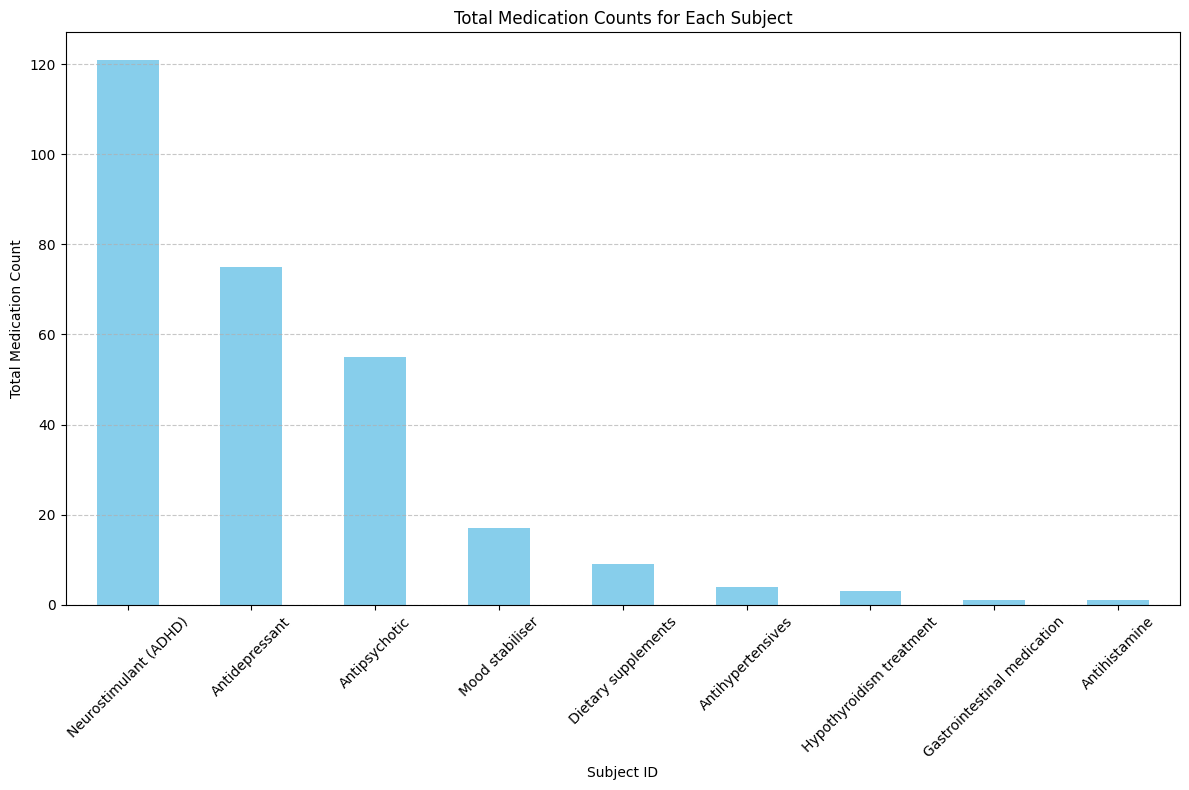

In [405]:
# Plotting
plt.figure(figsize=(12, 8))
medication_counts_df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Total Medication Counts for Each Subject')
plt.xlabel('Subject ID')
plt.ylabel('Total Medication Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Explore the dataset: Descriptive statistics

In [406]:
ASD_phenotypic.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1040.000000,1112.000000,1112.000000,364.000000,1040.000000,917.000000,931.000000,378.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,1112.000000,100.000000,94.000000
mean,50752.684353,1.515288,0.639423,17.048864,1.147482,60.567225,108.380962,107.812432,106.625134,19.767196,...,11.636364,9.909091,11.545455,10.127273,10.363636,8.763636,9.890909,1.312050,12.951700,20.519255
std,447.680666,0.499991,0.828849,8.036419,0.354745,47.495811,15.072062,16.244305,15.339533,5.527245,...,3.014555,3.187201,2.651472,3.232099,2.914610,2.821634,2.753266,0.463539,2.193555,5.244446
min,50002.000000,1.000000,0.000000,6.470000,1.000000,-100.000000,41.000000,42.000000,37.000000,2.000000,...,4.000000,3.000000,7.000000,2.000000,2.000000,4.000000,1.000000,1.000000,8.290000,6.530000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,52.750000,99.000000,98.000000,97.000000,16.000000,...,10.000000,7.000000,10.000000,7.500000,9.500000,7.000000,8.000000,1.000000,11.265000,17.422500
50%,50724.500000,2.000000,0.000000,14.660000,1.000000,75.000000,109.000000,108.000000,107.000000,20.000000,...,11.000000,11.000000,11.000000,10.000000,11.000000,9.000000,10.000000,1.000000,12.945000,19.945000
75%,51153.250000,2.000000,1.000000,20.085000,1.000000,91.000000,119.000000,119.000000,117.000000,24.000000,...,13.000000,12.000000,12.500000,12.500000,12.000000,10.500000,12.000000,2.000000,14.462500,22.645000
max,51607.000000,2.000000,4.000000,64.000000,2.000000,100.000000,148.000000,180.000000,157.000000,30.000000,...,19.000000,15.000000,19.000000,17.000000,14.000000,15.000000,16.000000,2.000000,17.940000,35.430000


# NUMERICAL EXPLORATION

The dataset has 1112 raws anf 74 colums

In [407]:
ASD_phenotypic.shape

(1112, 74)

Now we check the presence of missing values catalogated as None or numpy.NaN

In [408]:
nan_values = ASD_phenotypic.isna().sum()

# Filter columns with NaN values
columns_with_nan = nan_values[nan_values > 0]


# Print the number of attributes with NaN values
print("Number of attributes with NaN values:", len(columns_with_nan))

# Print the columns with NaN values and their corresponding counts
print("Attributes with NaN values and their counts:")
pd.set_option('display.max_rows', 74)
columns_with_nan



Number of attributes with NaN values: 67
Attributes with NaN values and their counts:


DSM_IV_TR                            72
HANDEDNESS_CATEGORY                 326
HANDEDNESS_SCORES                   748
FIQ                                  72
VIQ                                 195
PIQ                                 181
FIQ_TEST_TYPE                       169
VIQ_TEST_TYPE                       278
PIQ_TEST_TYPE                       259
ADI_R_SOCIAL_TOTAL_A                734
ADI_R_VERBAL_TOTAL_BV               733
ADI_RRB_TOTAL_C                     734
ADI_R_ONSET_TOTAL_D                 815
ADI_R_RSRCH_RELIABLE                721
ADOS_MODULE                         605
ADOS_TOTAL                          697
ADOS_COMM                           722
ADOS_SOCIAL                         721
ADOS_STEREO_BEHAV                   781
ADOS_RSRCH_RELIABLE                 736
ADOS_GOTHAM_SOCAFFECT               847
ADOS_GOTHAM_RRB                     842
ADOS_GOTHAM_TOTAL                   839
ADOS_GOTHAM_SEVERITY                839
SRS_VERSION                         881


Distribution of NANs

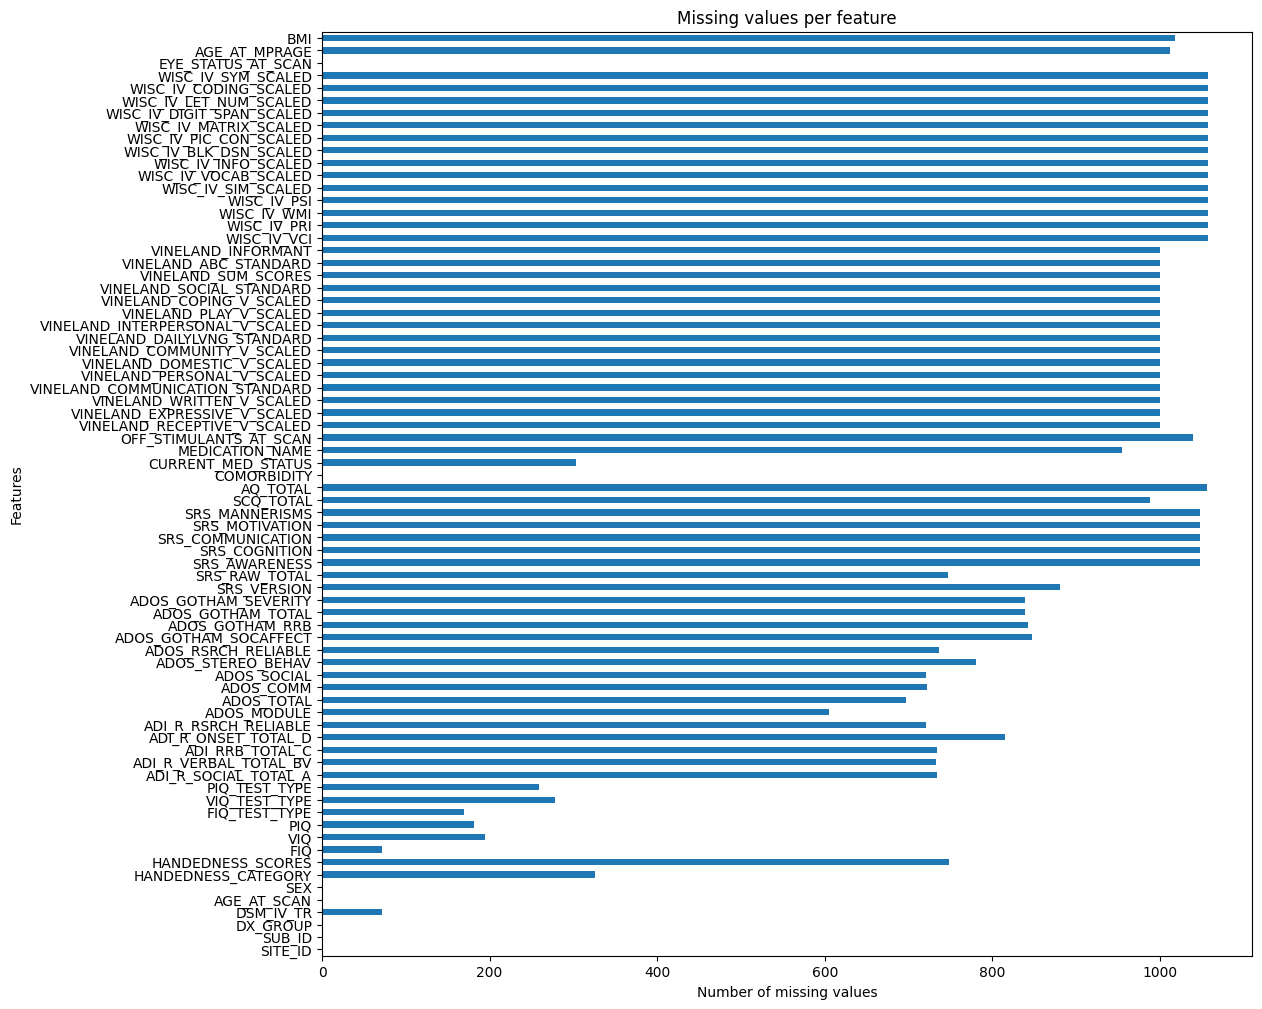

In [409]:
nan_values.plot(kind='barh', figsize=(12,12), title='Missing values per feature')
plt.xlabel('Number of missing values')
plt.ylabel('Features')
plt.show()

Is there some attribute with only missing values?

In [410]:

columns_only_nan = nan_values[nan_values == ASD_phenotypic.shape[0]]
print(len(columns_only_nan))

0


As there are too much, maybe is usefull to understand which columns haven't NaN values.

In [411]:
# Filter columns without NaN values
columns_without_nan = nan_values[nan_values == 0]

# Print the columns with NaN values and their corresponding counts
print("Attributes without NaN values and their counts:")
columns_without_nan

Attributes without NaN values and their counts:


SITE_ID               0
SUB_ID                0
DX_GROUP              0
AGE_AT_SCAN           0
SEX                   0
COMORBIDITY           0
EYE_STATUS_AT_SCAN    0
dtype: int64

There are maybe some subjects that has only missing values?

Max missing values encountered for a subject: 64
Min missing values encountered for a subject: 22


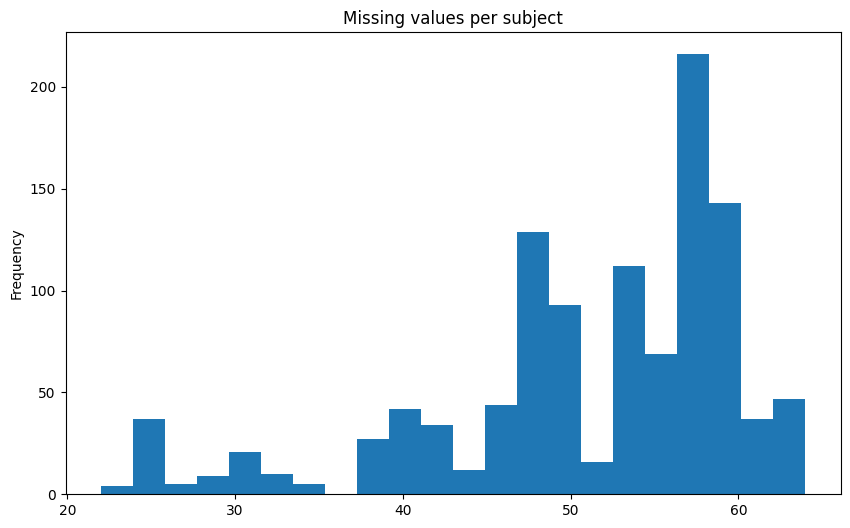

In [412]:
nan_values = ASD_phenotypic.T.isna().sum()

# Filter columns with NaN values
subjects_with_nan = nan_values[nan_values > 0]

print("Max missing values encountered for a subject: " +str(max(subjects_with_nan)))
print("Min missing values encountered for a subject: " +str(min(nan_values)))
subjects_with_nan.plot(kind='hist', bins=22, figsize=(10,6), title='Missing values per subject')
plt.show()


Let's have a look on the general statistics for the numerical attributes.

In [413]:
ASD_phenotypic.describe()

,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,ADI_R_SOCIAL_TOTAL_A,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
count,1112.000000,1112.000000,1040.000000,1112.000000,1112.000000,364.000000,1040.000000,917.000000,931.000000,378.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,1112.000000,100.000000,94.000000
mean,50752.684353,1.515288,0.639423,17.048864,1.147482,60.567225,108.380962,107.812432,106.625134,19.767196,...,11.636364,9.909091,11.545455,10.127273,10.363636,8.763636,9.890909,1.312050,12.951700,20.519255
std,447.680666,0.499991,0.828849,8.036419,0.354745,47.495811,15.072062,16.244305,15.339533,5.527245,...,3.014555,3.187201,2.651472,3.232099,2.914610,2.821634,2.753266,0.463539,2.193555,5.244446
min,50002.000000,1.000000,0.000000,6.470000,1.000000,-100.000000,41.000000,42.000000,37.000000,2.000000,...,4.000000,3.000000,7.000000,2.000000,2.000000,4.000000,1.000000,1.000000,8.290000,6.530000
25%,50354.750000,1.000000,0.000000,11.658575,1.000000,52.750000,99.000000,98.000000,97.000000,16.000000,...,10.000000,7.000000,10.000000,7.500000,9.500000,7.000000,8.000000,1.000000,11.265000,17.422500
50%,50724.500000,2.000000,0.000000,14.660000,1.000000,75.000000,109.000000,108.000000,107.000000,20.000000,...,11.000000,11.000000,11.000000,10.000000,11.000000,9.000000,10.000000,1.000000,12.945000,19.945000
75%,51153.250000,2.000000,1.000000,20.085000,1.000000,91.000000,119.000000,119.000000,117.000000,24.000000,...,13.000000,12.000000,12.500000,12.500000,12.000000,10.500000,12.000000,2.000000,14.462500,22.645000
max,51607.000000,2.000000,4.000000,64.000000,2.000000,100.000000,148.000000,180.000000,157.000000,30.000000,...,19.000000,15.000000,19.000000,17.000000,14.000000,15.000000,16.000000,2.000000,17.940000,35.430000


We need to handle missing values. But how?
Is really necessary to fullfill all of them? Can we maybe make some feature selection previously?


To make random forest for features selections

In [414]:
'''# Assuming 'data' is your DataFrame and 'target' is your target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2, random_state=42)

# Convert categorical variables to numeric using one-hot encoding (if needed)
# For example:
# X_train = pd.get_dummies(X_train)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Optionally, visualize feature importances
# (e.g., create a bar plot with feature names on the x-axis and importance scores on the y-axis)'''

"# Assuming 'data' is your DataFrame and 'target' is your target variable\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2, random_state=42)\n\n# Convert categorical variables to numeric using one-hot encoding (if needed)\n# For example:\n# X_train = pd.get_dummies(X_train)\n\n# Train the Random Forest model\nrf_model = RandomForestClassifier(random_state=42)\nrf_model.fit(X_train, y_train)\n\n# Get feature importance scores\nfeature_importances = rf_model.feature_importances_\n\n# Optionally, visualize feature importances\n# (e.g., create a bar plot with feature names on the x-axis and importance scores on the y-axis)"

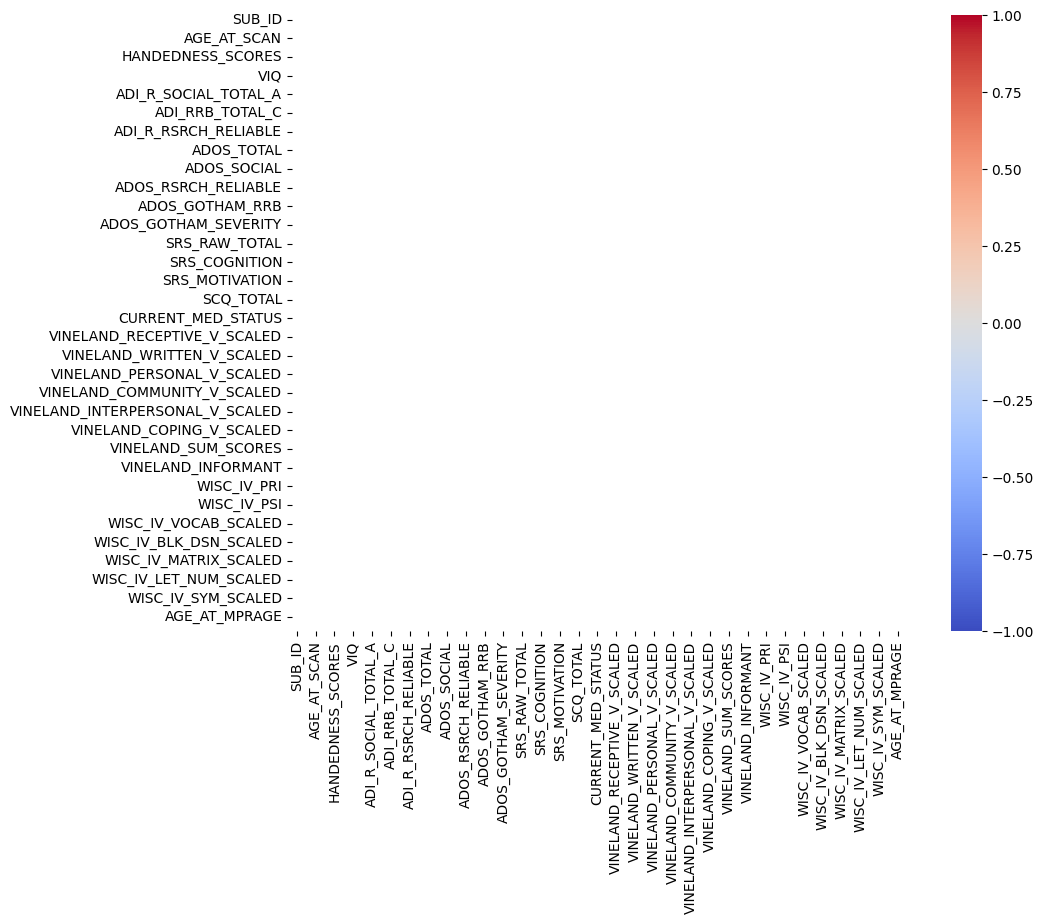

In [415]:
#vogliamo individuare e capire cosa sono questi object
numeric = ASD_phenotypic.select_dtypes(include=['float64',"int64"]).dropna()
numeric.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric.drop('DX_GROUP',axis = 1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()

Drop attribute if:
- Only unique values
- Only missing values

# Entropy

In [416]:
'''
# Calcola la distribuzione delle frequenze dei valori non mancanti nella feature 'SITE_ID'
site_id_counts = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=True)

# Calcola la proporzione di ciascun valore rispetto al totale dei dati
site_id_proportions = site_id_counts / site_id_counts.sum()

# Calcola l'entropia della distribuzione dei valori non mancanti
site_id_entropy = -(site_id_proportions * np.log2(site_id_proportions)).sum()

# Stampa l'entropia della feature 'SITE_ID'
print('Considering the feature')
print("Entropia di SITE_ID:", site_id_entropy)
'''

'\n# Calcola la distribuzione delle frequenze dei valori non mancanti nella feature \'SITE_ID\'\nsite_id_counts = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=True)\n\n# Calcola la proporzione di ciascun valore rispetto al totale dei dati\nsite_id_proportions = site_id_counts / site_id_counts.sum()\n\n# Calcola l\'entropia della distribuzione dei valori non mancanti\nsite_id_entropy = -(site_id_proportions * np.log2(site_id_proportions)).sum()\n\n# Stampa l\'entropia della feature \'SITE_ID\'\nprint(\'Considering the feature\')\nprint("Entropia di SITE_ID:", site_id_entropy)\n'

## Entropy Function

In [417]:
def calculate_entropy(column):
    # Sostituisci i valori NaN con "Missing" solo se la colonna è di tipo object
    if column.dtype == 'category':
        # Aggiungi "Missing" alle categorie esistenti
        column = column.cat.add_categories("Missing")
        column_filled = column.fillna("Missing")
    else:
        column_filled = column.fillna("Missing")  # Se è numerica
        
    # Calcola la distribuzione di probabilità delle categorie
    value_counts = column_filled.value_counts()
    probabilities = value_counts / value_counts.sum()
    
    # Calcola l'entropia
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy


## Entropy with "Missing"

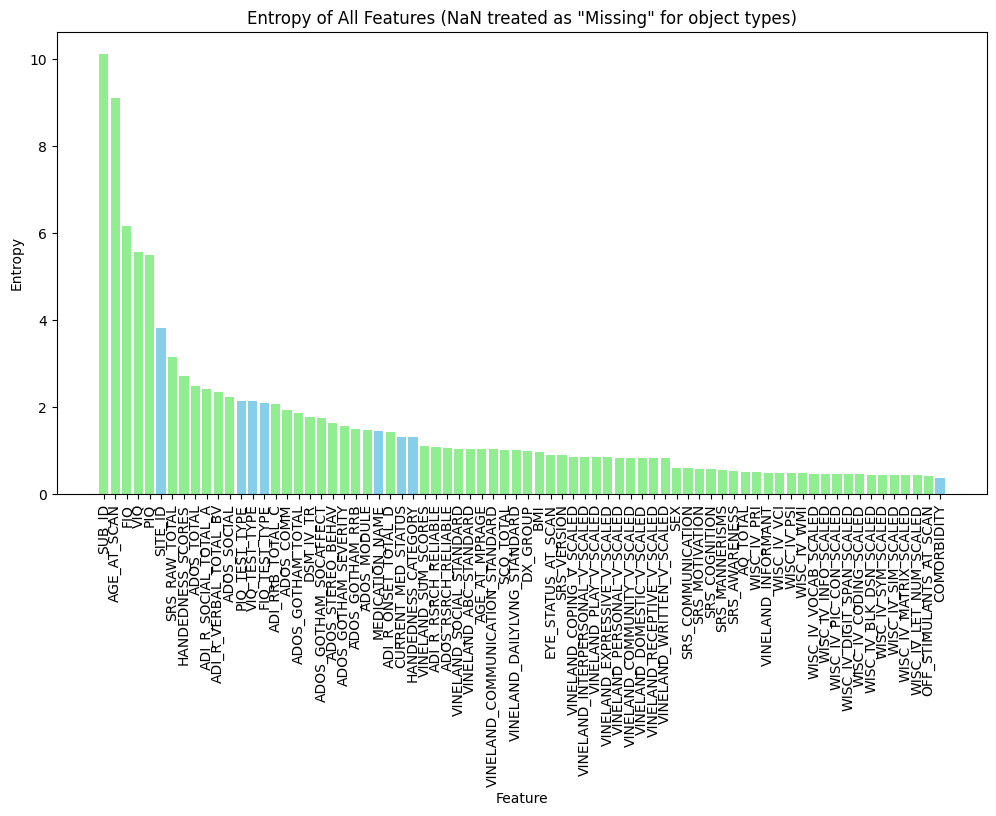

In [418]:
# Calcola l'entropia per tutte le colonne
all_entropy = {}
for column in ASD_phenotypic.columns:
    all_entropy[column] = calculate_entropy(ASD_phenotypic[column])

# Ordina il dizionario in base ai valori di entropia in ordine decrescente
sorted_entropy = {k: v for k, v in sorted(all_entropy.items(), key=lambda item: item[1], reverse=True)}

# Plot dell'entropia per tutte le colonne
# Definisci i colori per le feature categoriche e numeriche
color_categorical = 'skyblue'
color_numerical = 'lightgreen'
plt.figure(figsize=(12, 6))
plt.bar(sorted_entropy.keys(), sorted_entropy.values(), color=[color_categorical if col in category_columns.columns else color_numerical for col in sorted_entropy.keys()])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Entropy')
plt.title('Entropy of All Features (NaN treated as "Missing" for object types)')
plt.show()

## Entropy with NaN 

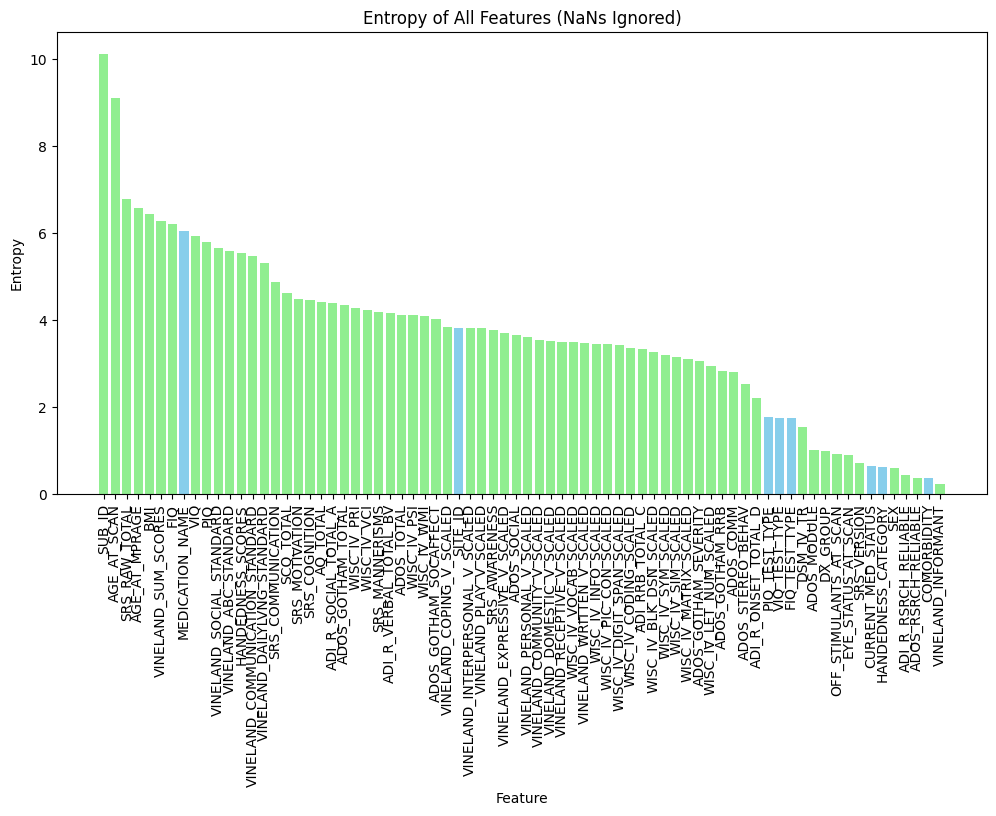

In [419]:
# Calcolo dell'entropia per tutte le colonne
all_entropy_dropna = {}

for column in ASD_phenotypic.columns:
    # Rimuovi i valori NaN dalla colonna
    column_without_nan = ASD_phenotypic[column].dropna()
    
    # Se la colonna è vuota dopo aver rimosso i NaN, imposta l'entropia a 0
    if column_without_nan.empty:
        entropy = 0
    else:
        # Calcola la distribuzione di probabilità delle categorie
        value_counts = column_without_nan.value_counts()
        probabilities = value_counts / value_counts.sum()
        
        # Calcola l'entropia
        entropy = -np.sum(probabilities * np.log2(probabilities))
    # Memorizza l'entropia calcolata per la colonna
    all_entropy_dropna[column] = entropy

# Plot dell'entropia per tutte le colonne
# Ordina il dizionario in base ai valori di entropia in ordine decrescente
sorted_entropy_dropna = {k: v for k, v in sorted(all_entropy_dropna.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(12, 6))
plt.bar(sorted_entropy_dropna.keys(), sorted_entropy_dropna.values(), color=[color_categorical if col in category_columns.columns else color_numerical for col in sorted_entropy_dropna.keys()])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Entropy')
plt.title('Entropy of All Features (NaNs Ignored)')
plt.show()


## Comparison between two entropies

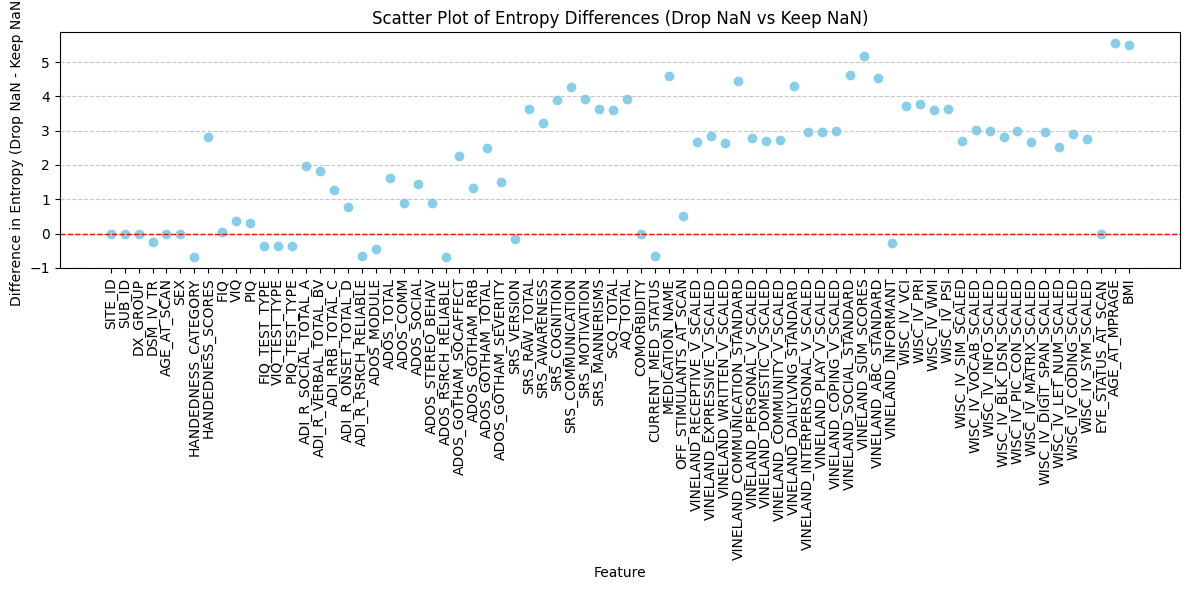

In [420]:
# Sovrapposizione dei due plot

# Calcola le differenze tra le entropie con e senza NaN per ogni feature
differences = {}
for column in all_entropy.keys():
    difference = all_entropy_dropna[column] - all_entropy[column]
    differences[column] = difference

# Crea il grafico a dispersione delle differenze
plt.figure(figsize=(12, 6))
plt.scatter(range(len(differences)), list(differences.values()), color='skyblue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Aggiungi una linea orizzontale a y=0 per la visualizzazione
plt.xlabel('Feature')
plt.ylabel('Difference in Entropy (Drop NaN - Keep NaN)')
plt.title('Scatter Plot of Entropy Differences (Drop NaN vs Keep NaN)')
plt.xticks(range(len(differences)), list(differences.keys()), rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
